In [1]:
# Dependencies

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

from DataSource import DataSource
from cnn_lstm import CNNLSTMModel

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Options
trend_length = 1
cnn_length = 20
lstm_length = 6
symbol = "ETHUSDT"
start_time = '2024-01-01'
end_time = '2024-04-01'
# val_start_time = '2024-01-01'
# val_end_time = '2024-04-01'
test_start_time = '2024-04-01'
test_end_time = '2024-05-01'
interval = '1h'
batch_size = 1
ohclv_length = 5
num_lstm_layers = 8
cnn_embedding_length = 16
lstm_hidden_dim = 64

num_folds = 4

dataLoader = {
    "trend_length": trend_length,
    "cnn_length": cnn_length,
    "lstm_length": lstm_length,
    "symbol": symbol,
    "start_time": start_time,
    "end_time": end_time,
    "interval": interval,
    "batch_size": batch_size
}

test_dataLoader = {
    "trend_length": trend_length,
    "cnn_length": cnn_length,
    "lstm_length": lstm_length,
    "symbol": symbol,
    "start_time": test_start_time,
    "end_time": test_end_time,
    "interval": interval,
    "batch_size": batch_size
}


In [4]:
# Save Data
data = DataSource(**dataLoader)
test_data = DataSource(**test_dataLoader)
with open("./trained_Data", 'wb') as f:
    pickle.dump(data, f)


In [5]:
# Load Data
with open('./trained_Data', 'rb') as f:
    data = pickle.load(f)

In [6]:
# Initialize Model
model = CNNLSTMModel(
    cnn_length = cnn_length, 
    cnn_embedding_length = cnn_embedding_length, 
    ohclv_length = ohclv_length, 
    lstm_hidden_dim = lstm_hidden_dim, 
    output_dim= 1,
    num_lstm_layers= num_lstm_layers
).to(device)

In [7]:
# Loss function & optimizer
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# k-fold cross validation
k_folds = 6
epochs = 10
learning_rate = 0.005

kf = KFold(n_splits=k_folds, shuffle=False)
train_losses = []
val_losses = []
fold_results = []

inputLoader = data.cnn_data
labelLoader = data.label_data
for fold, (train_index, val_index) in enumerate(kf.split(inputLoader)):
    print(f'Fold {fold+1}')
    
    # Initialize Model and Optimizer inside the fold loop
    model = CNNLSTMModel(
        cnn_length=cnn_length, 
        cnn_embedding_length=cnn_embedding_length, 
        ohclv_length=ohclv_length, 
        lstm_hidden_dim=lstm_hidden_dim, 
        output_dim=1,
        num_lstm_layers=num_lstm_layers
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Clear losses for each fold
    fold_train_losses = []
    fold_val_losses = []

    train_inputs = [inputLoader[i] for i in train_index]
    train_labels = [labelLoader[i] for i in train_index]
    val_inputs = [inputLoader[i] for i in val_index]
    val_labels = [labelLoader[i] for i in val_index]
    
    for epoch in range(epochs):
        train_loss = 0.0
        for batch_inputs, batch_labels in zip(train_inputs, train_labels):
            if batch_size != batch_inputs.shape[0]: continue
            if batch_size != batch_labels.shape[0]: continue
            inputs = torch.tensor(batch_inputs, dtype=torch.float32).to(device)
            labels = torch.tensor(batch_labels, dtype=torch.float32).to(device)
            ohclv = torch.tensor(data.lstm_data[0][:batch_size], dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(inputs, ohclv)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_inputs)
        fold_train_losses.append(train_loss)
        print(f'[{epoch + 1}] loss: {train_loss:.5f}')

        # Validation loss 계산
        val_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_labels in zip(val_inputs, val_labels):
                if batch_size != batch_inputs.shape[0]: continue
                if batch_size != batch_labels.shape[0]: continue
                inputs = torch.tensor(batch_inputs, dtype=torch.float32).to(device)
                labels = torch.tensor(batch_labels, dtype=torch.float32).to(device)
                ohclv = torch.tensor(data.lstm_data[0][:batch_size], dtype=torch.float32).to(device)

                output = model(inputs, ohclv)
                loss = criterion(output, labels)
                val_loss += loss.item()

        val_loss /= len(val_inputs)
        fold_val_losses.append(val_loss)
        print(f'Validation loss after epoch {epoch + 1}: {val_loss:.5f}')

    train_losses.append(fold_train_losses)
    val_losses.append(fold_val_losses)
    fold_results.append(val_loss)

avg_val_loss = sum(fold_results) / len(fold_results)
print(f'Average Validation Loss: {avg_val_loss:.5f}')

Fold 1


C:\Users\lahl0\AppData\Local\Temp\ipykernel_17980\1272333781.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(batch_labels, dtype=torch.float32).to(device)


[1] loss: 619.57937


C:\Users\lahl0\AppData\Local\Temp\ipykernel_17980\1272333781.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(batch_labels, dtype=torch.float32).to(device)


Validation loss after epoch 1: 968.85709
[2] loss: 485.14628
Validation loss after epoch 2: 1123.50670
[3] loss: 461.00494
Validation loss after epoch 3: 1004.46254
[4] loss: 475.74988
Validation loss after epoch 4: 1030.40682
[5] loss: 468.34474
Validation loss after epoch 5: 958.25024
[6] loss: 470.54287
Validation loss after epoch 6: 1043.13062
[7] loss: 476.01597
Validation loss after epoch 7: 1198.64436
[8] loss: 474.44310
Validation loss after epoch 8: 1235.45037
[9] loss: 476.33804
Validation loss after epoch 9: 1077.94521
[10] loss: 482.57049
Validation loss after epoch 10: 1054.19601
Fold 2
[1] loss: 615.45218
Validation loss after epoch 1: 1090.85478
[2] loss: 471.24970
Validation loss after epoch 2: 1275.22713
[3] loss: 494.62674
Validation loss after epoch 3: 1184.26183
[4] loss: 468.46364
Validation loss after epoch 4: 1012.54970
[5] loss: 476.10860
Validation loss after epoch 5: 1012.25872
[6] loss: 479.55286
Validation loss after epoch 6: 1144.51588
[7] loss: 484.43091
V

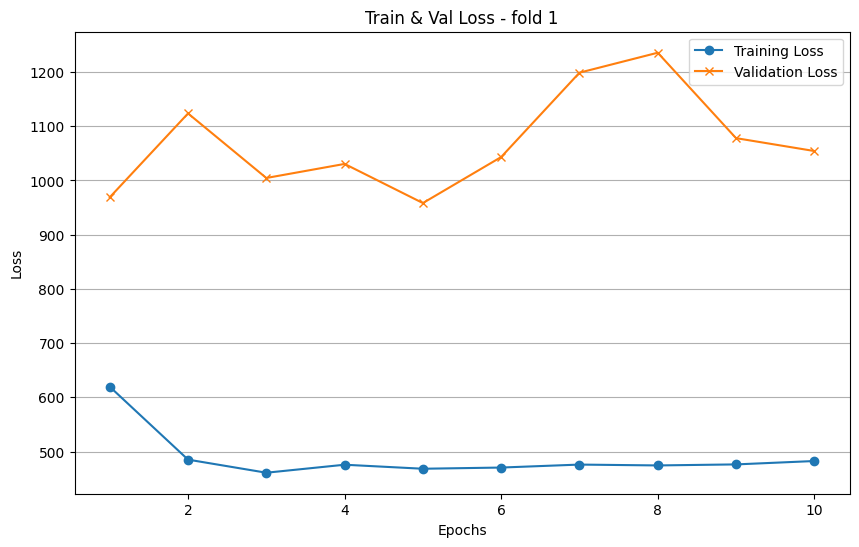

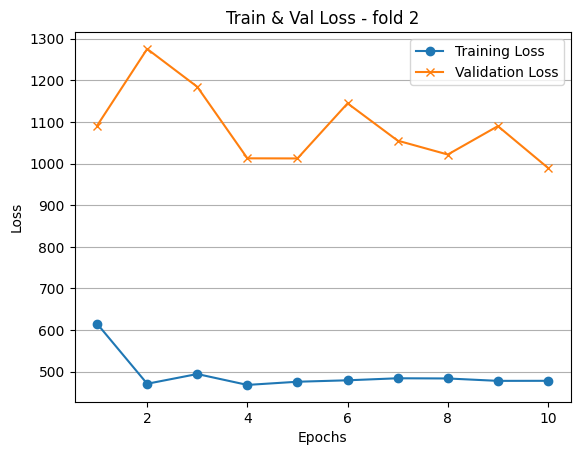

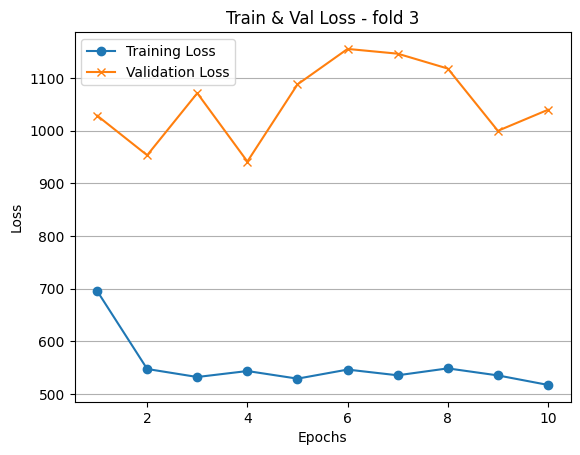

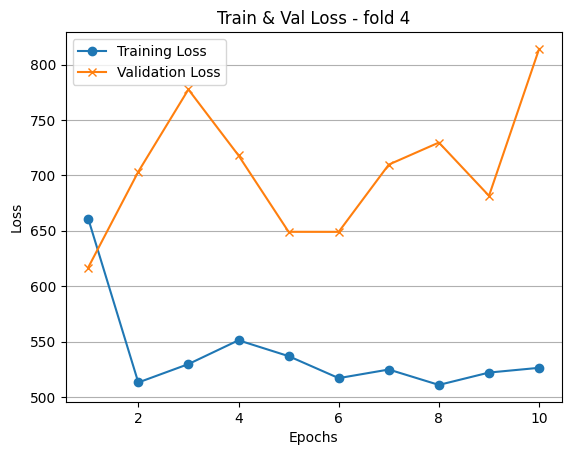

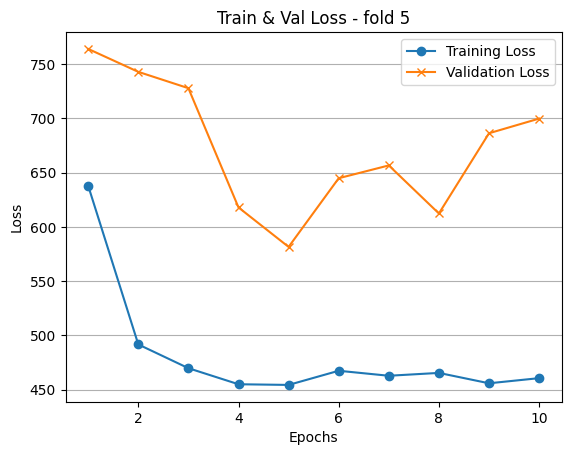

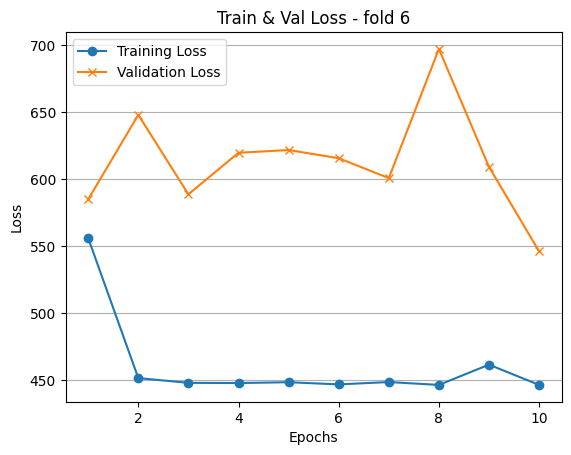

In [12]:
# plot
epoch_indices = list(range(1, epochs + 1))

plt.figure(figsize=(10, 6))
for i in range(k_folds):
    plt.plot(epoch_indices, train_losses[i], label='Training Loss', marker='o')
    plt.plot(epoch_indices, val_losses[i], label='Validation Loss', marker='x')
    plt.title(f'Train & Val Loss - fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.yscale('log')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

In [14]:
# test loss
inputLoader = test_data.cnn_data
labelLoader = test_data.label_data
n_batch = len(inputLoader)
test_losses = []
test_loss = 0.0
for batch in range(n_batch):
    inputs = torch.tensor(inputLoader[batch], dtype=torch.float32).to(device)
    labels = torch.tensor(labelLoader[batch], dtype=torch.long).to(device)  # long 타입으로 변환
    ohclv = torch.tensor(test_data.lstm_data[batch], dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(inputs, ohclv)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_losses.append(loss.item())

test_loss /= n_batch
print('test loss: %.5f' %test_loss)

C:\Users\lahl0\AppData\Local\Temp\ipykernel_17980\2698447312.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labelLoader[batch], dtype=torch.long).to(device)  # long 타입으로 변환


test loss: 677.88002
